In [1]:
import numpy as np
import jax.numpy as jnp
import jax
import math

from utils.function_utils import polynomial, taylor_expand_2d, polynomial_multiply, polynomial_sum, polynomial_power, print_polynomial, build_powers
from utils.function_utils import integrate_taylor_polynomial, derivative_t_polynomial, derivative_alpha_polynomial, taylor_expand_2d, matching_coeffs

from utils.distribution_utils import construct_pdf, construct_cdf

# Plot
import matplotlib.pyplot as plt
from rikabplotlib.plot_utils import newplot


No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


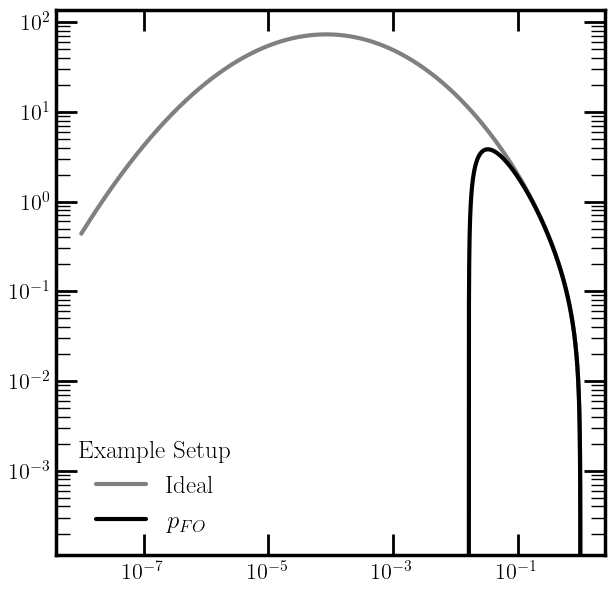

In [2]:
# Problem-dependent functions 
def t_from_x(x):
    return jnp.log(1/x)

def x_from_t(t):
    return jnp.exp(-t)


def p_ideal(t, alpha, params):
    alpha_bar = alpha #* 4/3 / jnp.pi
    return jnp.exp(-0.5 * alpha_bar * t**2) * alpha_bar * t


# Taylor expansion of p(t| alpha) = exp(-alpha * t**2)(alpha * t)
def p_t(t, alpha, params):
    alpha_bar = alpha #* 4/3 / jnp.pi
    return alpha_bar * t -  0.5 * alpha_bar**2 * t**3

p_x_ideal = lambda x, alpha, params: p_ideal(t_from_x(x), alpha, params) * jnp.abs(1/x)
p_x = lambda x, alpha, params: p_t(t_from_x(x), alpha, params) * jnp.abs(1/x)

def p_x(x, alpha, params):
    return p_t(t_from_x(x), alpha, params) * jnp.abs(1/x)


# Plot
xs = jnp.logspace(-8, 0, 10000)

fig, ax = newplot("full")
ax.plot(xs, p_x_ideal(xs, 0.118, None), label="Ideal", color = "grey")
ax.plot(xs, p_x(xs, 0.118, None), label=r"$p_{FO}$", color = "black")

ax.set_xscale("log")
ax.set_yscale("log")

plt.legend(title = "Example Setup")





# Complex Root Finding

In [3]:
import jax.numpy.linalg as jla
from utils.function_utils import build_powers

def polynomial_roots(c):


    # N = c.shape[0] - 1

    # companion_matrix = jnp.zeros((N, N))
    # eye = jnp.eye(N-1)
    # companion_matrix = companion_matrix.at[1:, :-1].set(eye)
    # companion_matrix = companion_matrix.at[:, -1].set(-c[:-1] / c[-1])


    # return jla.eigvals(companion_matrix)

    # # print(companion_matrix)
    # # print(jnp.linalg.eigvals(companion_matrix))

    
    roots = jnp.roots(c[::-1], strip_zeros=False)
    # print(roots)
    return roots



def collapse_2d_coeffs(alpha, params):

    M, N = params.shape

    alpha_powers = build_powers(alpha, M)  # shape (M,)

    return alpha_powers @ params


@jax.jit
def roots_from_params(alpha, params):

    collapsed_params = collapse_2d_coeffs(alpha, params)
    return polynomial_roots(collapsed_params)

vmapped_polynomial_roots = jax.vmap(polynomial_roots)
vmapped_roots_from_params= jax.vmap(roots_from_params, in_axes=(0, None))




In [17]:
def root_first_derivative(alpha, root, params):

    # print(root)

    # params is an array c_mn such that p(t, alpha) = sum_m sum_n c_mn alpha^m t^n

    alpha_deriv_params = derivative_alpha_polynomial(params)
    t_deriv_params = derivative_t_polynomial(params)


    # # if both are zero, return -1
    eps = 1e-10

    # print("alpha", polynomial(root, alpha, alpha_deriv_params))
    # print("t", polynomial(root, alpha, t_deriv_params))

    # print("Root: ", root)
    # print("Alpha: ", alpha)
    # if jnp.abs(polynomial(root, alpha, alpha_deriv_params)) < eps: # and jnp.abs(polynomial(root, alpha, t_deriv_params)) < eps:
    #     if jnp.abs(polynomial(root, alpha, t_deriv_params)) < eps:
    #         return -1.0 + 0.0j
        # return -1.0 + 0.0j

    return (-1.0 + 0.0j) * jnp.nan_to_num(polynomial(root, alpha, alpha_deriv_params) / polynomial(root, alpha, t_deriv_params) , nan=1.0)


# @jax.jit
def get_complex_derivative(func):

    def deriv(alpha, z, coeff):

        _, pullback = jax.vjp(func, alpha, z, coeff)
        return pullback(1.0+0.0j)[0]
    
    return deriv

def taylor_expand_root(root, coeffs, order):

    root = jnp.array(root, dtype=jnp.complex64)
    output_coeffs = [root, ]
    # print("Root: ", root)


    derivatives = [root_first_derivative]
    for i in range(1, order ):

       derivatives.append(get_complex_derivative(derivatives[-1]))

     

    for i in range(order):
        print("Derivative", i+1, derivatives[i](0.00+0.0j, root, coeffs))
        output_coeffs.append(derivatives[i](0.00+0.0j, root, coeffs) * (1 / math.factorial(i+1)) ) 

    
    return jnp.array(output_coeffs)


# vmapped_first_derivative_at_zero = jax.vmap(root_first_derivative_at_zero, in_axes=(0, None))
# second_derivative_at_zero = jax.grad(root_first_derivative_at_zero, argnums=0)
# vmapped_second_derivative_at_zero = jax.vmap(second_derivative_at_zero, in_axes=(0, None))
# third_derivative_at_zero = jax.grad(second_derivative_at_zero, argnums=0)
# vmapped_third_derivative_at_zero = jax.vmap(third_derivative_at_zero, in_axes=(0, None))
# fourth_derivative_at_zero = jax.grad(third_derivative_at_zero, argnums=0)
# vmapped_fourth_derivative_at_zero = jax.vmap(fourth_derivative_at_zero, in_axes=(0, None))


print(build_powers(2.0j,3))
print(2.0j * 2.0j)


test_params = jnp.array([[1.0, 0, 1.0], [0.0, 2.0, 0.0]])
print(roots_from_params(0.0, test_params))




# taylor_expand_root = (taylor_expand_root, static_argnums=(2,))
print(taylor_expand_root(roots_from_params(0.0, test_params)[1], test_params, 2))

[ 1.+0.j  0.+2.j -4.+0.j]
(-4+0j)
[-0.+1.j  0.-1.j]
Derivative 1 (-1+0j)
Derivative 2 1j
[ 0.-1.j  -1.+0.j   0.+0.5j]


(100, 3)
[-0.10952377+1.2968904j -0.10952377-1.2968904j -0.04467345+0.j       ]
Derivative 1 (-0.067827135-0.9202746j)
Derivative 2 (-0.39403906+0.18739522j)
[-0.10952377+1.2968904j  -0.06782714-0.9202746j  -0.19701953+0.09369761j]
Derivative 1 (-0.067827135+0.9202746j)
Derivative 2 (-0.39403906-0.18739522j)
[-0.10952377-1.2968904j  -0.06782714+0.9202746j  -0.19701953-0.09369761j]
Derivative 1 (-0.19704479+0j)
Derivative 2 (0.7137796+0j)
[-0.04467345+0.j -0.19704479+0.j  0.3568898 +0.j]


(-10.0, 10.0)

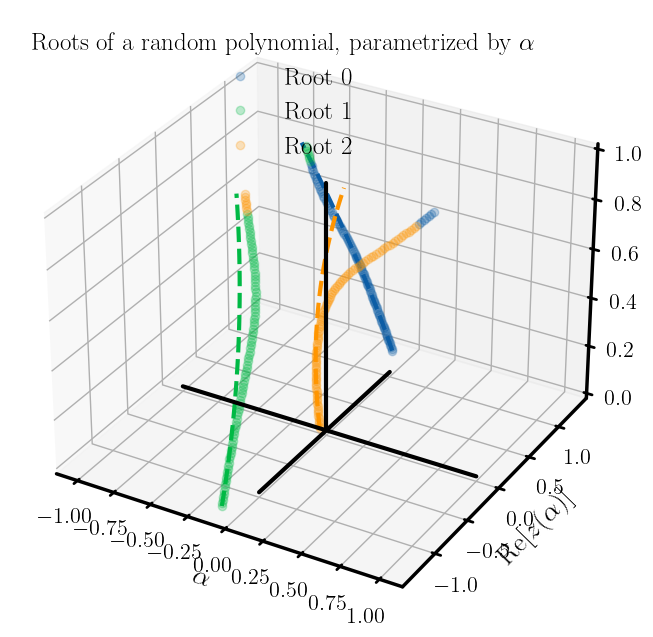

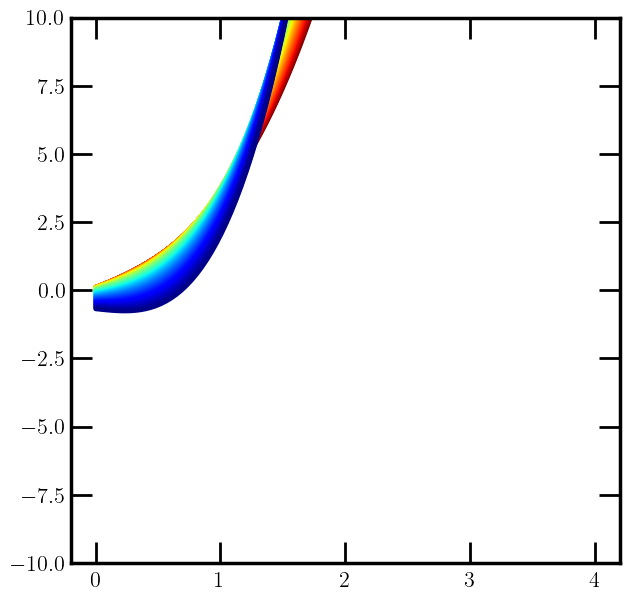

In [24]:
# Test some random coefficients
seed = 0
params = jax.random.normal(jax.random.PRNGKey(seed), (4, 4))
alphas = jnp.linspace(0.0, 1, 100)

roots = vmapped_roots_from_params(alphas, params)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

print(roots.shape)
roots_at_0 = roots[0,:]
# roots1_at_0 = vmapped_first_derivative_at_zero(roots[0,:], params) 
# roots2_at_0 = vmapped_second_derivative_at_zero(roots[0,:], params)
# roots3_at_0 = vmapped_third_derivative_at_zero(roots[0,:], params)
# roots4_at_0 = vmapped_fourth_derivative_at_zero(roots[0,:], params)


print(roots_at_0)
# print(roots1_at_0)

# roots_grad_2 = jax.jacobian(roots_grad_1, argnums=0, holomorphic=True)
# vmapped_roots_grad_2 = jax.vmap(roots_grad_2, in_axes=(0, None))
# print(roots_grad_1(jnp.array(0.5, dtype= jnp.complex64), params).shape)


# taylor_roots =  roots1_at_0 * alphas[:, None] + roots[0] + roots2_at_0 * alphas[:, None]**2 / 2


for i in range(roots.shape[1]):
    ax.plot(roots.real[:, i], roots.imag[:, i], alphas, label=f"Root {i}", color = "C" + str(i), linestyle = "None", marker = "o", alpha= 0.25)
    

    taylor_roots_i = taylor_expand_root(roots_at_0[i], params, 2)
    taylor_roots = jnp.sum(taylor_roots_i[:, None] * alphas[None, :]**jnp.arange(0, 3)[:, None], axis = 0)
    print(taylor_roots_i)
    ax.plot(taylor_roots.real[:], taylor_roots.imag[:], alphas, linestyle="--", color = "C" + str(i))
# ax.plot(taylor_roots.real, taylor_roots.imag, alphas, linestyle="--")


plt.xlabel(r"$\alpha$")
plt.ylabel(r"Re$[z(\alpha)]$")
plt.legend(title = r"Roots of a random polynomial, parametrized by $\alpha$", loc = "upper left")

# Draw x, y and z axes
ax.plot([0, 0], [0, 0], [-0, 1], color = "black")
ax.plot([0, 0], [-1, 1], [0, 0], color = "black")
ax.plot([-1, 1], [0, 0], [0, 0], color = "black")


# Plot the value of the polynomial for different alphas
fig, ax = newplot("full")

alphas = jnp.linspace(0, 1, 100)
ts = jnp.linspace(0, 4, 100)
vmapped_polynomial = jax.vmap(polynomial, in_axes=(0, None, None))
for (i, alpha) in enumerate(alphas):


    # jet colormap
    color = plt.cm.jet_r(i / len(alphas))

    ax.plot(ts, vmapped_polynomial(ts, alpha, params), color = color)

plt.ylim(-10, 10)




In [63]:
def polynomial_from_roots(roots):


    # roots is a (M,N) array of N roots, which are the roots of a polynomial of degree M
    # We want to construct the 2d polynomial with these roots

    M, N = roots.shape

    # Construct the polynomial
    poly = jnp.array([[1.0,],])
    for i in range(N):

        # Make the monomonial (t - roots[0, i] - roots[1, i]*alpha - ... - roots[M, i]*alpha**M)
        # 2D array of shape (M+1, 1)

        monomial = jnp.zeros((M, 2))
        monomial = monomial.at[0, 1].set(1.0)
        monomial = monomial.at[:, 0].set(-roots[:, i])

        print(monomial)

        # monomial = jnp.array([[-roots[0, i], 1.0], *[[-roots[m+1, i], 0.0]  for m in range(M) ]      ])
        # print(monomial.shape)
        # print(monomial)
        # print(roots[1], roots)
        # print(*[[-roots[m+1, i], 0.0]  for m in range(M) ] )

        poly = polynomial_multiply(poly, monomial)

    return poly

roots = jnp.array([[-1, 1]])


poly = polynomial_from_roots(roots)
print_polynomial(poly)
print(roots_from_params(0.0, poly))

[[1. 1.]]
[[-1.  1.]]
c_0,0 = -1.00e+00 c_0,1 = 0.00e+00 c_0,2 = 1.00e+00 
[-1.+0.j  1.+0.j]


/home/rikab/Documents/Research/NNEFT/jax/utils/function_utils.py:138: UserWarning: Explicitly requested dtype <class 'jax.numpy.float64'> requested in zeros is not available, and will be truncated to dtype float32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  c = jnp.zeros((M+1, N+1), dtype=jnp.float64)


c_0,0 = 0.00e+00 c_0,1 = 0.00e+00 c_0,2 = 0.00e+00 c_0,3 = 0.00e+00 c_0,4 = 0.00e+00 c_0,5 = 0.00e+00 c_0,6 = 0.00e+00 c_0,7 = 0.00e+00 c_0,8 = 0.00e+00 
c_1,0 = 0.00e+00 c_1,1 = 0.00e+00 c_1,2 = 5.00e-01 c_1,3 = 0.00e+00 c_1,4 = 0.00e+00 c_1,5 = 0.00e+00 c_1,6 = 0.00e+00 c_1,7 = 0.00e+00 c_1,8 = 0.00e+00 
c_2,0 = 0.00e+00 c_2,1 = 0.00e+00 c_2,2 = 0.00e+00 c_2,3 = 0.00e+00 c_2,4 = 0.00e+00 c_2,5 = 0.00e+00 c_2,6 = 0.00e+00 c_2,7 = 0.00e+00 c_2,8 = 0.00e+00 
c_3,0 = 0.00e+00 c_3,1 = 0.00e+00 c_3,2 = 0.00e+00 c_3,3 = 0.00e+00 c_3,4 = 0.00e+00 c_3,5 = 0.00e+00 c_3,6 = 0.00e+00 c_3,7 = 0.00e+00 c_3,8 = 0.00e+00 
c_4,0 = 0.00e+00 c_4,1 = 0.00e+00 c_4,2 = 0.00e+00 c_4,3 = 0.00e+00 c_4,4 = 0.00e+00 c_4,5 = 0.00e+00 c_4,6 = 0.00e+00 c_4,7 = 0.00e+00 c_4,8 = 0.00e+00 


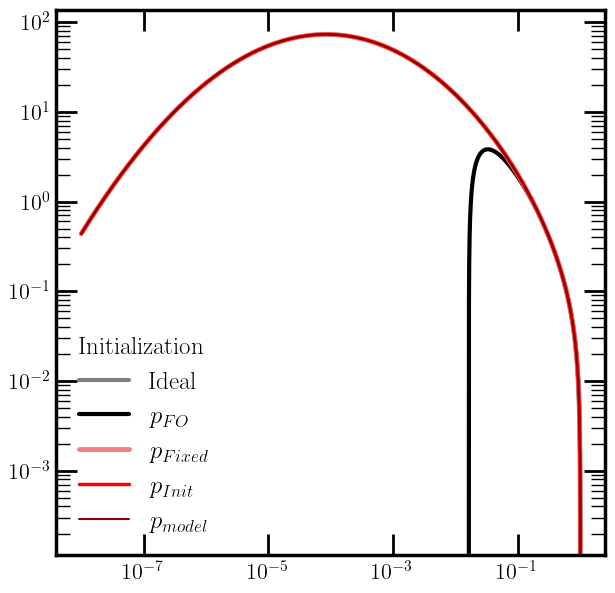

In [3]:

FIXED_MN = (2, 4)           # The coefficients of the distribution we cannot change
INITIALIZED_MN = (2, 4)     # The coefficients of the distribution we initialize the optimization with. Must be >= FIXED_MN
MODEL_MN = (4, 8)           # The coefficients of the model we are optimizing. Must be >= INITIALIZED_MN.


frozen_mask = jnp.zeros((MODEL_MN[0] + 1, MODEL_MN[1] + 1), dtype=bool)
frozen_mask = frozen_mask.at[:FIXED_MN[0] + 1, :FIXED_MN[1] + 1].set(True)


model_params = jnp.zeros((MODEL_MN[0] + 1, MODEL_MN[1] + 1))

matched_coeffs = matching_coeffs(p_t, INITIALIZED_MN[0], INITIALIZED_MN[1])
matched_coeffs = matched_coeffs[:INITIALIZED_MN[0] + 1, :INITIALIZED_MN[1] + 1]
model_params = model_params.at[:INITIALIZED_MN[0] + 1, :INITIALIZED_MN[1] + 1].set(matched_coeffs)

print_polynomial(model_params)


pdf = construct_pdf(polynomial, t_from_x)
vmapped_pdf = jax.vmap(pdf, in_axes=(0, None, None))

fig, ax = newplot("full")
ax.plot(xs, p_x_ideal(xs, 0.118, None), label="Ideal", color = "grey")
ax.plot(xs, p_x(xs, 0.118, None), label=r"$p_{FO}$", color = "black")

ax.plot(xs, vmapped_pdf(xs, 0.118, model_params[:FIXED_MN[0]+ 1, :FIXED_MN[1] + 1]), label=r"$p_{Fixed}$", color = "lightcoral", lw = 3.5)
ax.plot(xs, vmapped_pdf(xs, 0.118, model_params[:INITIALIZED_MN[0]+ 1, :INITIALIZED_MN[1] + 1]), label=r"$p_{Init}$", color = "red", lw = 2.5)
ax.plot(xs, vmapped_pdf(xs, 0.118, model_params), label=r"$p_{model}$", color = "darkred", lw = 1.5)

ax.set_xscale("log")
ax.set_yscale("log")

plt.legend(title = "Initialization")



# Machine Learn

In [4]:
import jax.numpy.linalg as jla
from utils.function_utils import build_powers

def polynomial_roots(c):

    
    roots = jnp.roots(c[::-1], strip_zeros=False)
    return roots



def collapse_2d_coeffs(alpha, params):

    M, N = params.shape

    alpha_powers = build_powers(alpha, M)  # shape (M,)

    return alpha_powers @ params


def roots_from_params(alpha, params):

    collapsed_params = collapse_2d_coeffs(alpha, params)
    return polynomial_roots(collapsed_params)

vmapped_polynomial_roots = jax.vmap(polynomial_roots)
vmapped_roots_from_params= jax.vmap(roots_from_params, in_axes=(0, None))

In [5]:
import optax
from tqdm import tqdm



def check_negativity(params):

    c = derivative_taylor_polynomial(params)
    alphas = jnp.linspace(0, 1, 10)
    roots = vmapped_roots_from_params(alphas, c)

    # print(roots[0])
    # print(roots[-1])
    
    # Check if any root is a positive real number
    eps = 1e-8

    bools = jnp.any((jnp.abs(roots.imag) < eps) * ( roots.real >= 0))
    return bools
    


def project_params(params, frozen_mask, projector_seed, xs, alphas, vmapped_polynomial):

    scale = +0.00000001

    # Sample from exponential distribution
    seed = projector_seed
    projector_seed = jax.random.split(seed)[0]
    projector = jax.random.exponential(projector_seed, shape=params.shape) * scale

    # While q is negative, keep sampling
    ts = t_from_x(xs)
    while check_negativity(params + projector):
        scale = scale * 1.1
        projector_seed = jax.random.split(projector_seed)[0]
        projector = jax.random.exponential(projector_seed, shape=params.shape) * scale

    return (params + projector) * (1 - frozen_mask) + params * frozen_mask


# Loss Functions
def loss(params, p, q, xs, alphas):

    ps = p(xs, alphas, params)
    qs = q(xs, alphas, params)

    eps = 1e-9
    log_p = jnp.log(jnp.abs(ps + eps))
    log_q = jnp.log(jnp.abs(qs + eps))

    # Add i*pi to the log of the negative values
    log_p = log_p + 1j * jnp.pi * (ps < 0)
    log_q = log_q + 1j * jnp.pi * (qs < 0)

    # Take the magnitude of the difference
    diff = jnp.abs(log_p - log_q)**2
    return jnp.mean(jnp.nan_to_num(diff))


loss_grad = jax.grad(loss, argnums=0)


# Training Loop
def train(target_p_x, M, N, model_params = None, frozen_mask = None, compile = True):

    # ML Stuff
    epochs = 500
    batch_size = 2048
    learning_rate = 0.0000001
    losses = []
    history = []

    # Initialize
    if model_params is None:
        frozen_mask = jnp.zeros((MODEL_MN[0] + 1, MODEL_MN[1] + 1), dtype=bool)
        frozen_mask = frozen_mask.at[:FIXED_MN[0] + 1, :FIXED_MN[1] + 1].set(True)


        model_params = jnp.zeros((MODEL_MN[0] + 1, MODEL_MN[1] + 1))

        matched_coeffs = matching_coeffs(p_t, INITIALIZED_MN[0], INITIALIZED_MN[1])
        matched_coeffs = matched_coeffs[:INITIALIZED_MN[0] + 1, :INITIALIZED_MN[1] + 1]
        model_params = model_params.at[:INITIALIZED_MN[0] + 1, :INITIALIZED_MN[1] + 1].set(matched_coeffs)
    

    # Optimizer
    optimizer = optax.adam(learning_rate)
    opt_state = optimizer.init(model_params)

    q = construct_pdf(polynomial, t_from_x)

    # vmap everything
    vmapped_p = jax.vmap(target_p_x, in_axes=(0, 0, None))
    vmapped_q = jax.vmap(q, in_axes=(0, 0, None))
    vmapped_loss = loss
    vmapped_loss_grad = loss_grad
    vmapped_polynomial = jax.vmap(polynomial, in_axes=(0, 0, None))

    # Compile everything (for speed)
    if compile:
        vmapped_p = jax.jit(vmapped_p)
        vmapped_q = jax.jit(vmapped_q)
        vmapped_loss = jax.jit(loss, static_argnums=(1, 2))
        vmapped_loss_grad = jax.jit(loss_grad, static_argnums=(1, 2))
        vmapped_polynomial = jax.jit(vmapped_polynomial)


    epoch_tqdm = tqdm(range(epochs))
    for i in epoch_tqdm:

        seed = jax.random.PRNGKey(i)
        xs_seed, alphas_seed, projector_seed = jax.random.split(seed, 3)

        # Sample some xs and alphas
        xs = jax.random.uniform(seed, shape=(batch_size,))
        alphas = jax.random.exponential(seed, shape=(batch_size,))

        # Reroll if any of the xs or alphas are 0
        eps = 1e-8
        while jnp.any(xs < eps) or jnp.any(alphas < 1e-8):
            xs_seed, alphas_seed = jax.random.split(xs_seed)
            xs = jax.random.uniform(xs_seed, shape=(batch_size,))
            alphas = jax.random.uniform(alphas_seed, shape=(batch_size,))

        # Compute the loss and the gradient
        loss_q = vmapped_loss(model_params, vmapped_p, vmapped_q, xs, alphas)
        gradient_q = vmapped_loss_grad(model_params, vmapped_p, vmapped_q, xs, alphas)

        # # Zero out the gradients of the frozen parameters
        gradient_q = gradient_q * (1 - frozen_mask)

        # Update only the UNFROZEN parameters
        updates, opt_state = optimizer.update(gradient_q, opt_state)
        model_params = optax.apply_updates(model_params, updates)
        model_params = project_params(model_params, frozen_mask, projector_seed, xs, alphas, vmapped_polynomial)


        # print_polynomial(gradient_q)


        epoch_tqdm.set_description(f"Loss = {loss_q}")
        losses.append(loss_q)
        history.append(model_params)

    return model_params, losses, history



In [6]:
trained_model_params, losses, history = train(p_x, MODEL_MN[0], MODEL_MN[1], model_params, frozen_mask, compile = True)

# Plot loss
fig, ax = newplot("full")
ax.plot(losses, color = "black")
plt.yscale("log")
plt.xlabel("Epoch")
plt.ylabel("Loss")


# Plot history
fig, ax = newplot("full")
for i in range(len(history)):
    xs = jnp.logspace(-8, 0, 10000)
    color = (i/len(history), 0, 1-i/len(history)) 
    ax.plot(xs, vmapped_pdf(xs, 0.118, history[i]), color = color,)

ax.set_xscale("log")
ax.set_yscale("log")



# Plot history
vmapped_polynomial = jax.vmap(polynomial, in_axes=(0, None, None))
fig, ax = newplot("full")
for i in range(len(history)):
    xs = jnp.logspace(-8, 0, 10000)
    t = t_from_x(xs)
    color = (i/len(history), 0, 1-i/len(history)) 
    ax.plot(t, vmapped_polynomial(t, 0.118, derivative_taylor_polynomial(history[i])), color = color,)

# ax.set_xscale("log")
# ax.set_yscale("log")

Loss = 0.11535756289958954:   7%|▋         | 37/500 [01:36<20:09,  2.61s/it]   


KeyboardInterrupt: 

c_0,0 = 0.00e+00 c_0,1 = 0.00e+00 c_0,2 = 0.00e+00 c_0,3 = 0.00e+00 c_0,4 = 0.00e+00 c_0,5 = -4.52e-06 c_0,6 = 1.41e-06 c_0,7 = 4.98e-06 c_0,8 = 2.18e-05 
c_1,0 = 0.00e+00 c_1,1 = 0.00e+00 c_1,2 = 5.00e-01 c_1,3 = 0.00e+00 c_1,4 = 0.00e+00 c_1,5 = -1.37e-05 c_1,6 = -1.26e-05 c_1,7 = -6.72e-06 c_1,8 = 3.19e-06 
c_2,0 = 0.00e+00 c_2,1 = 0.00e+00 c_2,2 = 0.00e+00 c_2,3 = 0.00e+00 c_2,4 = 0.00e+00 c_2,5 = -2.04e-05 c_2,6 = -2.01e-05 c_2,7 = -1.43e-05 c_2,8 = -5.25e-07 
c_3,0 = 6.40e-05 c_3,1 = 2.24e-06 c_3,2 = -8.53e-06 c_3,3 = -1.70e-05 c_3,4 = -1.69e-05 c_3,5 = -2.09e-05 c_3,6 = -2.25e-05 c_3,7 = -1.81e-05 c_3,8 = -8.12e-06 
c_4,0 = 5.54e-05 c_4,1 = 4.77e-06 c_4,2 = -6.89e-06 c_4,3 = -1.08e-05 c_4,4 = -1.55e-05 c_4,5 = -1.95e-05 c_4,6 = -2.20e-05 c_4,7 = -2.13e-05 c_4,8 = -8.91e-06 


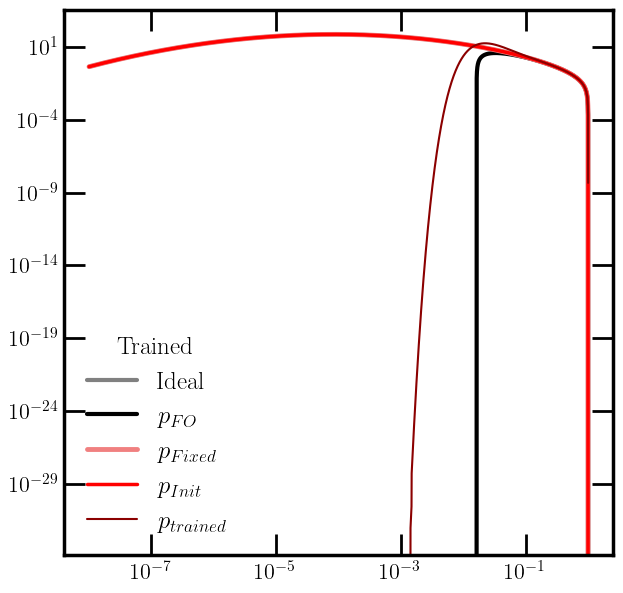

In [83]:
pdf = construct_pdf(polynomial, t_from_x)
vmapped_pdf = jax.vmap(pdf, in_axes=(0, None, None))

print_polynomial(trained_model_params)

fig, ax = newplot("full")
ax.plot(xs, p_x_ideal(xs, 0.118, None), label="Ideal", color = "grey")
ax.plot(xs, p_x(xs, 0.118, None), label=r"$p_{FO}$", color = "black")


ax.plot(xs, vmapped_pdf(xs, 0.118, model_params[:FIXED_MN[0]+ 1, :FIXED_MN[1] + 1]), label=r"$p_{Fixed}$", color = "lightcoral", lw = 3.5)
ax.plot(xs, vmapped_pdf(xs, 0.118, model_params[:INITIALIZED_MN[0]+ 1, :INITIALIZED_MN[1] + 1]), label=r"$p_{Init}$", color = "red", lw = 2.5)
ax.plot(xs, vmapped_pdf(xs, 0.118, trained_model_params), label=r"$p_{trained}$", color = "darkred", lw = 1.5)

ax.set_xscale("log")
ax.set_yscale("log")

# plt.ylim(-2, 2)

plt.legend(title = "Trained")

# Complex Stuff

[ 6.3463426e+00+0.41747195j  6.3463426e+00-0.41747195j
  6.7794633e-01+4.5105267j   6.7794633e-01-4.5105267j
 -3.7729845e+00+2.383569j   -3.7729845e+00-2.383569j
 -7.0190531e-06+0.j        ]
True
1.0000005
1.0000005
-180.37971


(-0.5, 10.0)

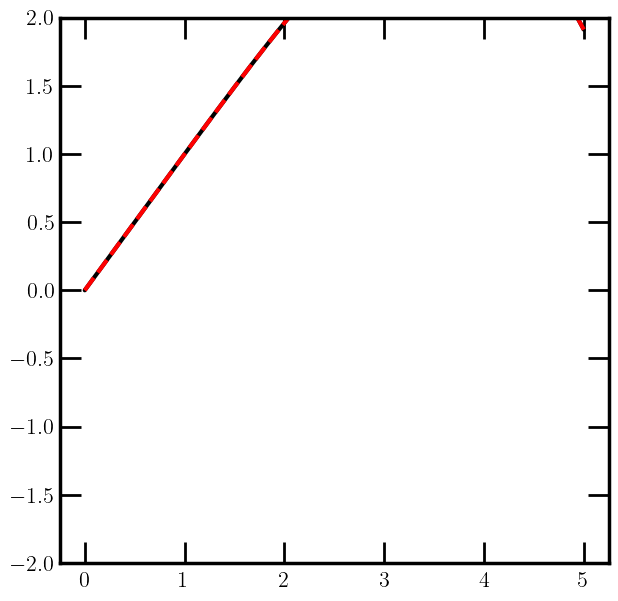

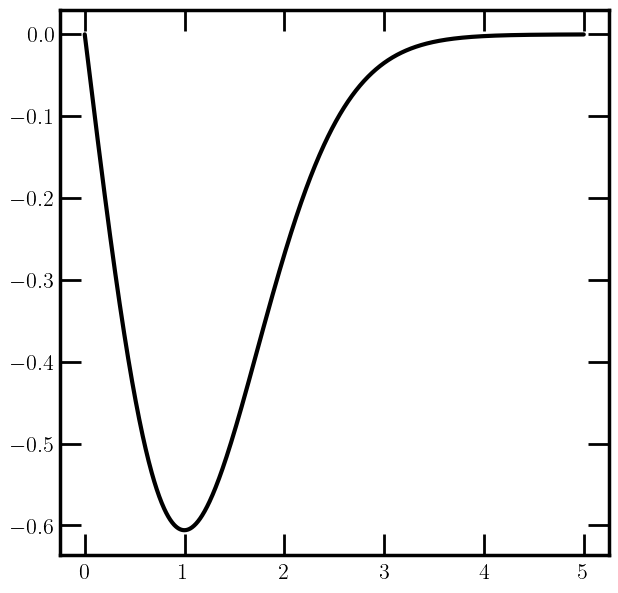

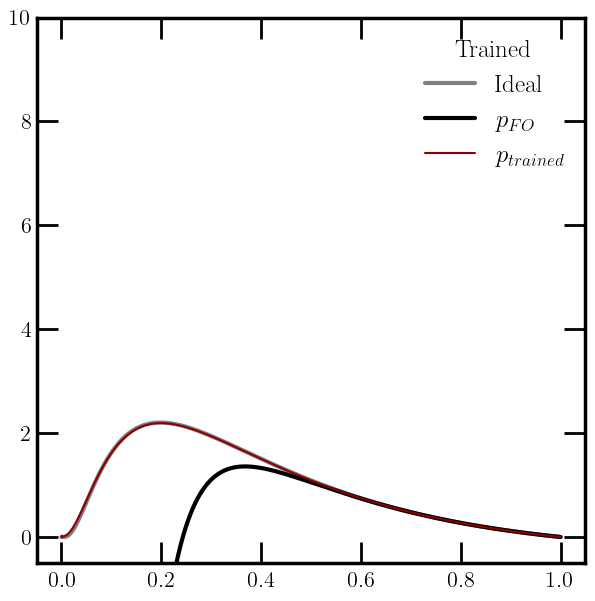

In [86]:

c = derivative_taylor_polynomial(trained_model_params)
roots = polynomial_roots(collapse_2d_coeffs(1, c))
print(roots)


print(check_negativity(trained_model_params))

fig, ax = newplot("full")
ts = jnp.linspace(0, 5, 1000)
vmapped_polynomial = jax.vmap(polynomial, in_axes=(0, None, None))
ax.plot(ts, vmapped_polynomial(ts, 1, c), color = "black")
ax.plot(ts, vmapped_polynomial(ts, 1, derivative_taylor_polynomial(history[-1])), color = color, ls = "--")
plt.ylim(-2, 2)



fig, ax = newplot("full")
pdf_t = construct_pdf(polynomial, lambda x: x)
vmapped_pdf_t = jax.vmap(pdf_t, in_axes=(0, None, None))
plt.plot(ts, vmapped_pdf_t(ts, 1, trained_model_params), color = "black")

fig, ax = newplot("full")
ax.plot(xs, p_x_ideal(xs, 1, None), label="Ideal", color = "grey")
ax.plot(xs, p_x(xs, 1, None), label=r"$p_{FO}$", color = "black")
ax.plot(xs, vmapped_pdf(xs, 1, trained_model_params), label=r"$p_{trained}$", color = "darkred", lw = 1.5)


plt.legend(title = "Trained")

# print the integrals
print(np.trapz(vmapped_pdf(xs, 0.118, trained_model_params), xs))
print(np.trapz(p_x_ideal(xs, 0.118, None), xs))
print(np.trapz(p_x(xs, 0.118, None), xs))


plt.ylim(-0.5, 10)
# plt.xscale("log")
# plt.yscale("log")



# print(polynomial(4, 1, trained_model_params))
# print(pdf(x_from_t(4), 1, trained_model_params))


(Array(nan, dtype=float32, weak_type=True), Array([[nan, nan, nan, nan],
       [nan, nan, nan, nan],
       [nan, nan, nan, nan]], dtype=float32))


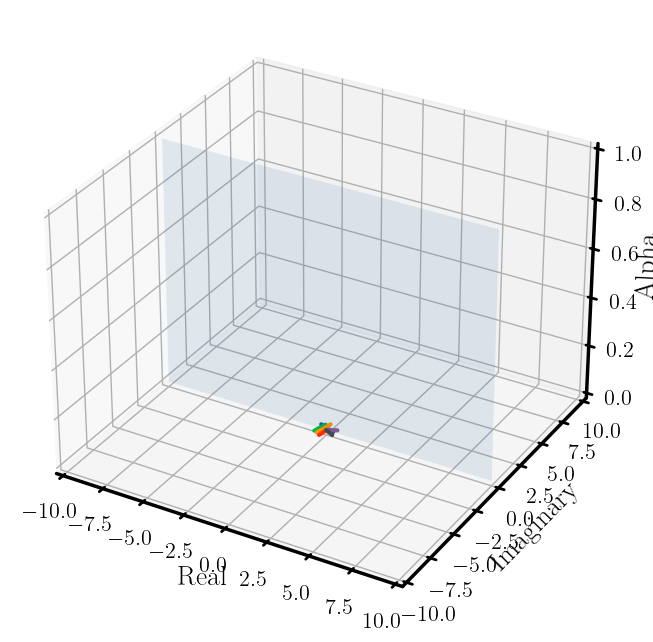

In [132]:

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

alphas = jnp.linspace(0.00, 0.00001, 2)


c = derivative_taylor_polynomial(trained_model_params)
c_matched = derivative_taylor_polynomial(matched_coeffs)

roots = vmapped_roots_from_params(alphas, c)
roots_matched = vmapped_roots_from_params(alphas, c_matched)


# # for i in range(roots.shape[1]):
# print(roots[1])
# print(roots_matched[1], matched_coeffs)


# Gradient of the roots
# roots_grad = jax.jacobian(roots_from_params, argnums=0, holomorphic=False)
# print(roots_grad(jnp.array(0.0, dtype= jnp.complex64), c_matched) * alphas[1])
# 

eye = jnp.eye(3, dtype= jnp.complex64)
print(jax.vjp(roots_from_params, 0.00, c_matched)[1](eye[0]))

# Plot the roots
for i in range(roots.shape[1]):


    plt.plot(roots[:, i].real, roots[:, i].imag, alphas)

ax.set_zlabel('Alpha')
ax.set_xlabel('Real')
ax.set_ylabel('Imaginary')

# Solid line at y = z = 0
ax.plot(jnp.zeros_like(alphas), jnp.zeros_like(alphas), alphas , color='black', lw=2)

# Solid line at x = y = 0
ax.plot(alphas * 2, jnp.zeros_like(alphas), jnp.zeros_like(alphas), color='black', lw=2)

# Solid line at x = z = 0
ax.plot(jnp.zeros_like(alphas), alphas , jnp.zeros_like(alphas), color='black', lw=2)

plt.xlim(-10, 10)
plt.ylim(-10, 10)


# Draw plane at y = 0 for x > 0

ax.plot_surface( jnp.linspace(-10, 10, 100), jnp.zeros((100, 100)), jnp.linspace(0, 1, 100)[:, None], alpha=0.1)

In [ ]:
def root_polynomial(t, alpha, roots):

    c